# <center>Foundations of Deep Learning for the Social Sciences:</br>Day 2 Python Tutorial</center>

Today, we will demonstrate how deep learning methods can be used to fit and extend traditional latent variable models used in [structural equation modeling](https://en.wikipedia.org/wiki/Structural_equation_modeling) and [item response theory](https://en.wikipedia.org/wiki/Item_response_theory).

The methods used here come primarily from two papers. The first paper is by [van Kesteren and Oberski (2022)](#refs) and demonstrates how to fit structural equation models using backpropagation and stochastic gradient-based optimization. The second paper is by [Urban and Bauer (2021)](#refs) and demonstrates how to fit item response theory models using deep learning-based approximate inference methods.

Both papers have Python packages that make using the methods convenient: these are called [tensorsem](https://github.com/vankesteren/tensorsem) and [DeepIRTools](https://github.com/cjurban/deepirtools), respectively. If you have not already installed these packages, you can do so now using:

In [ ]:
!pip install https://github.com/vankesteren/tensorsem/archive/master.zip
!pip install deepirtools

Now, let's import the packages we'll be using.

In [1]:
import torch
import tensorsem as ts
import deepirtools

import pandas as pd
from pathlib import Path
import sys
import os
import urllib.request
import shutil
import numpy as np
import itertools

deepirtools.manual_seed(123) # Set seed for reproducibility.
                             # This sets seeds for PyTorch, NumPy, and the Python module "random".

## Holzinger-Swineford Example

We begin by analyzing the classic Holzinger-Swineford (HS) data set. HS consists of mental ability test scores of seventh- and eighth-grade children from two different schools and are typically fitted using a confirmatory 3-factor model. This is the model we'll fit in the following examples.

We will first fit the model using the Tensorsem package. Recall from lecture that structural equation models (SEMs) are fitted by minimizing a fitting function. Here, we will minimize the maximum likelihood fitting function:
\begin{equation}
F_{\text{ML}}(\boldsymbol{\theta}) = \log \lvert \boldsymbol{\Sigma}(\boldsymbol{\theta}) \rvert + \text{tr}\big[\mathbf{S} \boldsymbol{\Sigma}^{-1}(\boldsymbol{\theta}) \big], \nonumber
\end{equation}
where $\boldsymbol{\Sigma}(\boldsymbol{\theta})$ is the model-implied covariance matrix:
\begin{equation}
    \boldsymbol{\Sigma}(\boldsymbol{\theta}) = \boldsymbol{\Lambda} (\mathbf{I} - \mathbf{B}_0)^{-1} \boldsymbol{\Psi} (\mathbf{I} - \mathbf{B}_0)^{-\top} \boldsymbol{\Lambda}^\top + \boldsymbol{\Theta}, \nonumber
\end{equation}
with $\boldsymbol{\Lambda}$ the factor loadings matrix, $\mathbf{B}_0$ is the structural regression weight matrix, $\boldsymbol{\Theta}$ the residual covariance matrix, and $\boldsymbol{\Psi}$ the factor covariance matrix.

It's very easy to do SEM in deep learning frameworks. The fitting function can be constructed as the output of a computational graph (reproduced from [van Kesteren and Oberski, 2022](#refs)):
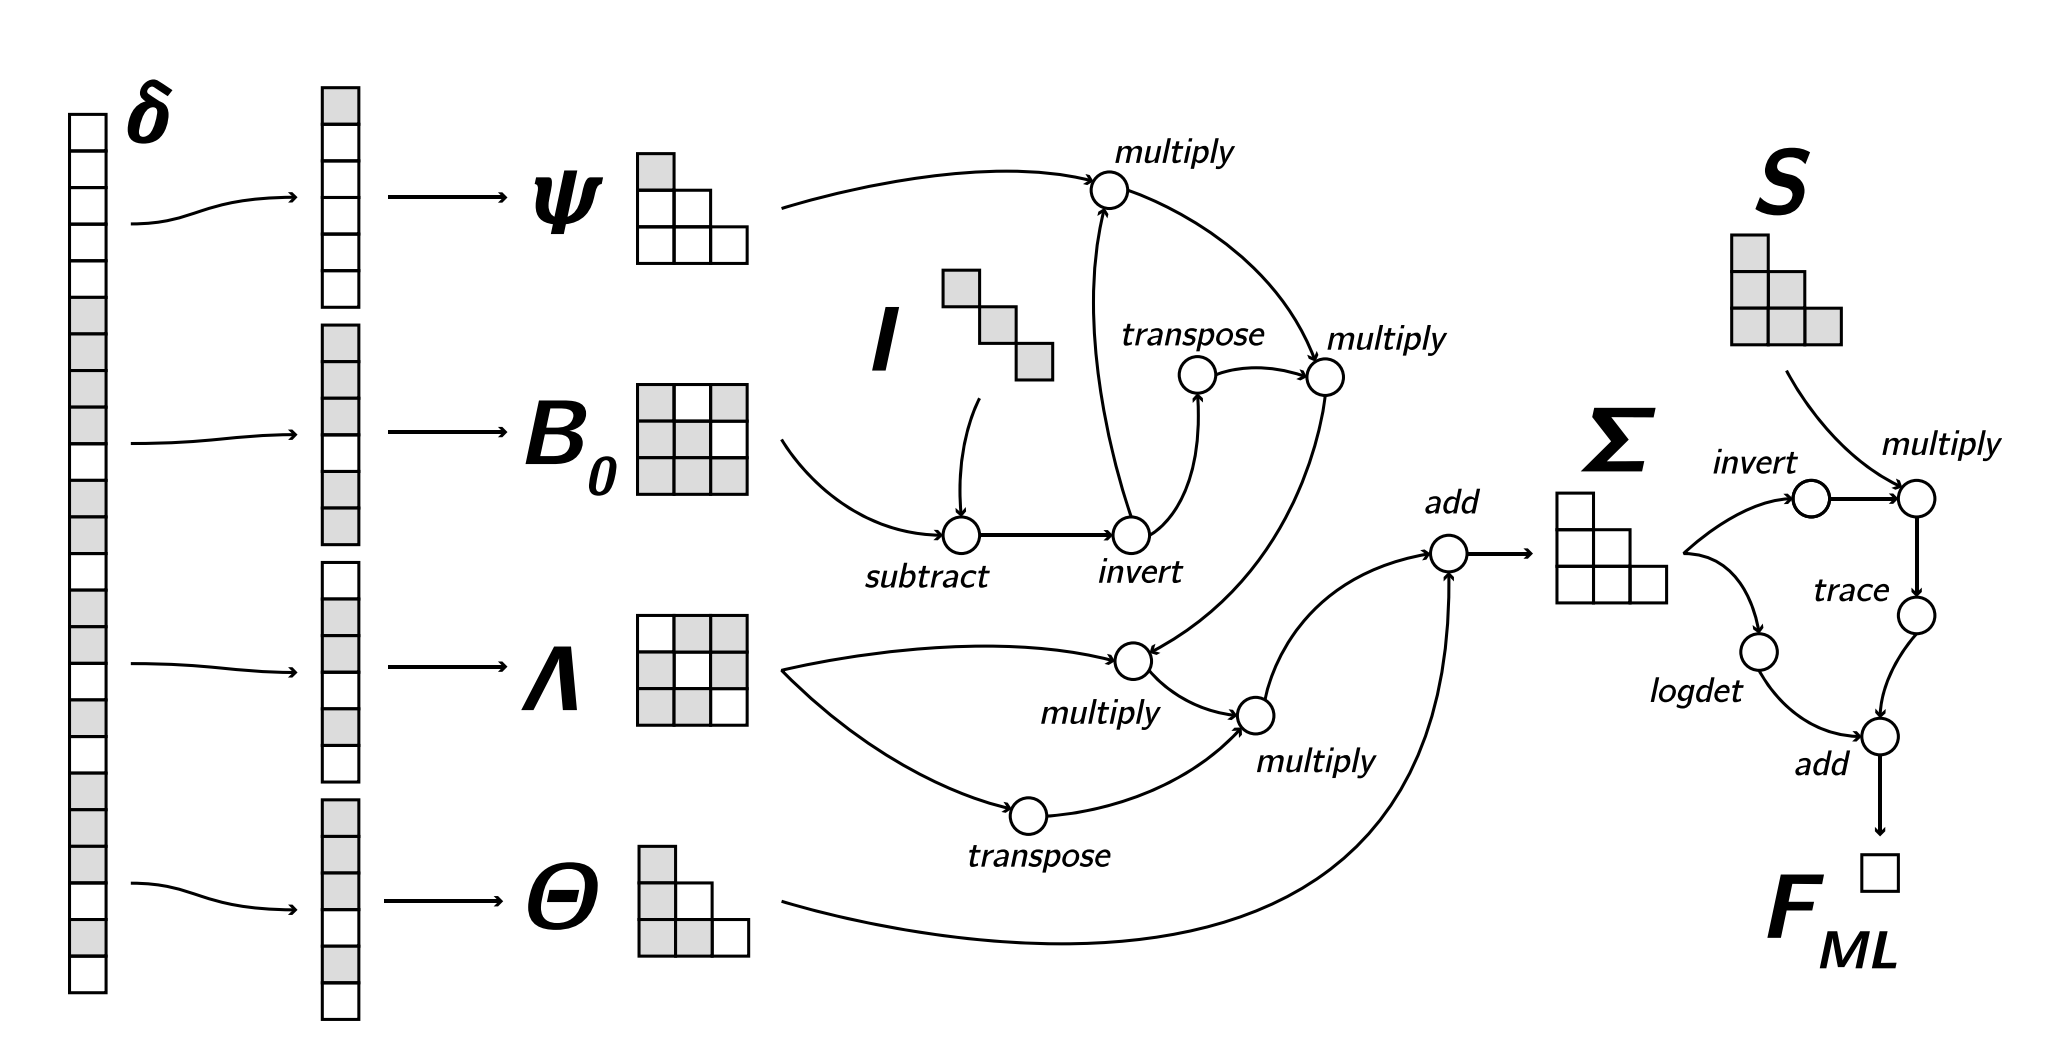

Tensorsem is a Python package that implements SEM in PyTorch. The following code for Tensorsem is taken directly from the Tensorsem GitHub repository with a few basic changes. 

In [2]:
data_dir = Path("./data")  # Directory where the data is stored.
lr = 0.01  # Learning rate for stochastic gradient optimizer.
tol = 1e-20  # Loss change tolerance.
max_iter = 5000  # Maximum number of epochs (i.e., full passes through the data set) allowed.

opts = ts.SemOptions.from_file(data_dir / "hs_mod.pkl")  # This defines starting values, constraints, free parameters,
                                                         # and parameter shapes. You need to specify this for every
                                                         # model you fit, which is unwieldly but gives you a decent
                                                         # amount of control.
df = pd.read_csv(data_dir / "hs.csv")[opts.ov_names]  # Read in data and order columns.
df -= df.mean(0)  # Center the data.
sample_size, n_items = df.shape

data = torch.tensor(df.values, dtype = torch.float64, requires_grad = False)

model = ts.StructuralEquationModel(opt = opts, dtype = torch.float64)  # Create the model.
optimizer = torch.optim.Adam(model.parameters(), lr = lr)  # Create stochastic gradient optimizer.
lls = []  # For saving the log-likelihood values during fitting.
for epoch in range(max_iter):
    if epoch % 100 == 1:
        print("Epoch:", epoch, " mean loss:", lls[-1] / sample_size)
    optimizer.zero_grad() 
    Sigma = model()  # This computes the model-implied covariance matrix.
    loss = ts.mvn_negloglik(data, Sigma)  # Compute the negative log-likelihood.
    lls.append(-loss.item())
    loss.backward()
    optimizer.step()
    if epoch > 1:
        if abs(lls[-1] - lls[-2]) < tol: # Stop if log-likelihood hasn't changed more than tolerance.
            break

Epoch: 1  mean loss: -13.187624323830814
Epoch: 101  mean loss: -12.417860568607015
Epoch: 201  mean loss: -12.417757236687828
Epoch: 301  mean loss: -12.417757231316038


In [3]:
print("\nLoadings:\n", model.Lam,
      "\n\nFactor covariance matrix:\n", model.Psi,
      "\n\nResidual covariance matrix:\n", model.Tht)


Loadings:
 tensor([[0.8996, 0.0000, 0.0000],
        [0.4979, 0.0000, 0.0000],
        [0.6562, 0.0000, 0.0000],
        [0.0000, 0.9897, 0.0000],
        [0.0000, 1.1016, 0.0000],
        [0.0000, 0.9166, 0.0000],
        [0.0000, 0.0000, 0.6195],
        [0.0000, 0.0000, 0.7309],
        [0.0000, 0.0000, 0.6700]], dtype=torch.float64, grad_fn=<TBackward0>) 

Factor covariance matrix:
 tensor([[1.0000, 0.4585, 0.4705],
        [0.4585, 1.0000, 0.2830],
        [0.4705, 0.2830, 1.0000]], dtype=torch.float64,
       grad_fn=<ViewBackward0>) 

Residual covariance matrix:
 tensor([[0.5491, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.1338, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8443, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.3712, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4463, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0

We now fit the same model using DeepIRTools, another PyTorch-based Python package that implements a number of latent factor models.

DeepIRTools uses an importance-weighted amortized variational estimator (I-WAVE) for the model parameters ([Urban and Bauer, 2021](#refs)). This estimator can be used for latent variable models with very complicated measurement models (e.g., models with neural networks). Unlike the SEM fitting function $F_{\text{ML}}(\boldsymbol{\theta})$, the I-WAVE loss &mdash; called the *importance-weighted evidence lower bound*, or IW-ELBO &mdash; is inherently stochastic, meaning that its value will change slightly *every* time it is computed.

The IW-ELBO is a lower bound on the exact log-likelihood that can be improved by increasing the number of importance samples drawn during fitting (e.g., increasing the `iw_samples` argument in the `fit()` method in DeepIRTools). As DeepIRTools fits the model and prints updates below, notice that it converges to essentially the same loss value as SEM, indicating that for this example the IW-ELBO is very close to the true log-likelihoood.

Determining convergence can be somewhat tricky for stochastic loss functions. DeepIRTools determines convergence by computing the average loss value over the past $100$ fitting iterations. If the best average loss does not change for a specified number of $100$-iteration intervals, the model is deemed converged. Convergence will be a bit slower in the small-scale setting using this approach, but will be quite fast with large sample sizes.

In [4]:
Q = torch.block_diag(*[torch.ones([3, 1])] * 3) # Binary matrix imposing simple structure on the loadings.

model = deepirtools.IWAVE(
    model_type = "normal", # Normal linear factor model.
    learning_rate = lr,
    Q = Q,
    ints_mask = torch.zeros(9), # Constrain all intercepts to zero.
    inference_net_sizes = [20], # Hidden layer size for inference neural network.
    latent_size = 3, # Number of latent variables.
    n_items = 9,
    correlated_factors = [0, 1, 2], # Which factors should be correlated.
    n_intervals = 10 # This is the convergence criterion for I-WAVE.
)
model.fit(data,
          batch_size = sample_size, # We are doing full sample gradient descent rather than
                                    # sampling mini-batches of observations. If requested, DeepIRTools
                                    # handles mini-batch sampling behind the scenes.
          iw_samples = 100) # Increasing iw_samples improves the approximation to the
                            # exact log-likelihood.


Initializing model parameters
Initialization ended in  0.0  seconds

Fitting started
Epoch =     1100 Iter. =     1101 Cur. loss =   12.40   Intervals no change =   10
Fitting ended in  26.03  seconds


Th estimates obtained by DeepIRTools are very close to the SEM estimates.

In [5]:
print("\nLoadings:\n", model.loadings,
      "\n\nFactor covariance matrix:\n", model.cov,
      "\n\nResidual covariance matrix:\n", model.residual_std.pow(2).diag())


Loadings:
 tensor([[0.9006, 0.0000, 0.0000],
        [0.4951, 0.0000, 0.0000],
        [0.6510, 0.0000, 0.0000],
        [0.0000, 0.9934, 0.0000],
        [0.0000, 1.1054, 0.0000],
        [0.0000, 0.9125, 0.0000],
        [0.0000, 0.0000, 0.6221],
        [0.0000, 0.0000, 0.7278],
        [0.0000, 0.0000, 0.6708]]) 

Factor covariance matrix:
 tensor([[1.0000, 0.4604, 0.4658],
        [0.4604, 1.0000, 0.2784],
        [0.4658, 0.2784, 1.0000]]) 

Residual covariance matrix:
 tensor([[0.5460, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.1346, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8484, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.3692, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4464, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3568, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0

## Big-Five Personality Factors Example

H-S is quite small, so let's try a large-scale example.

I begin by downloading and pre-processing the data set, which consists of over 1 million people's responses to 50 Big-Five personality factors items. There are 10 items designed to measure each personality factor (i.e., extraversion, emotional stability, agreeableness, conscientiousness, and openness) and each item has 5 response categories ranging from 1 = Disagree to 5 = Agree.

After some basic pre-processing, I cut the data set down to around 621K people.

In [6]:
# Download data.
filepath = "./data/IPIP-FFM-data-8Nov2018/data-final.csv"
if not os.path.exists(filepath):
    os.makedirs(os.path.dirname("./data/"), exist_ok=True)
    urllib.request.urlretrieve("https://openpsychometrics.org/_rawdata/IPIP-FFM-data-8Nov2018.zip",
                               "./data/ipip-ffm.zip")
    shutil.unpack_archive("./data/ipip-ffm.zip", "./data/")

# Pre-processing.
df = pd.read_csv(filepath, sep = "\t", header = 0)
df = df[df["IPC"] == 1] # Drop multiple submissions from same IP address.
df.iloc[:, :100] = df.iloc[:, :100].dropna() # Drop people with all NaN responses.
df = df[df.iloc[:, 0:50].sum(1) > 0] # Drop people with all missing responses.
df = df[(df["country"] != "NONE") & (~df["country"].isna())] # Drop people for whom no country was recorded.
rc_items = ["EXT2", "EXT4", "EXT6", "EXT8", "EXT10", "AGR1", "AGR3", "AGR5", "AGR7",
            "CSN2", "CSN4", "CSN6", "CSN8", "EST2", "EST4", "OPN2", "OPN4", "OPN6"]
df[rc_items] = ((1 - df[rc_items] / 5) * 5 + 1).mask(lambda col: col == 6, 0) # Reverse-code reverse-coded items.
Y = torch.from_numpy(df.iloc[:, :50].to_numpy()) - 1 # Collect item responses.
T = torch.from_numpy(df.iloc[:, 50:100].to_numpy()) / 1000 # Collect response times in seconds.

missing_mask = 1 * (Y != -1)
Y[Y == -1] = 0
T[T == 0] = 1e-7 # Set zero response times (which indicate missingness) to a small value.

keeps = (((T < 0).sum(dim = 1) == 0) & ((T > 100).sum(dim = 1) == 0)) # Drop negative or overly long response times
                                                                      # and missing baseline covariates.
Y, T, missing_mask = Y[keeps], T[keeps], missing_mask[keeps]

print(Y.shape) # Matrix of shape (sample_size, n_items).

torch.Size([621307, 50])


Let's fit a five-factor model to the Big-Five data using Tensorsem. We'll now use mini-batching due to the huge sample size.

In [7]:
lr = 0.01  # Learning rate for stochastic gradient optimizer.

batch_size = 100
checker = deepirtools.utils.ConvergenceChecker(n_intervals = 50,   # This determines convergence for stochastic
                                               log_interval = 100) # gradient optimizers by smoothing over intervals.

# As noted above, this is pretty unwieldly, but does provide a lot of control.
# This object is called a dictionary. It is a container for key : object pairs where
# key is a string and object is some object. Here, we're providing starting values,
# free values (i.e., which values should be estimated), fixed values, parameter shapes,
# and variable names, respectively.
opt_dict = {"delta_start" : (([1.] * 10 + [0.] * 50) * 4 + [1.] * 10 +
                             list(itertools.chain.from_iterable([[1.] + [0.] * (50 - i) for i in range(1, 51)])) +
                             list(itertools.chain.from_iterable([[1.] + [0.] * (5 - i) for i in range(1, 6)])) +
                             [0.] * 25
                            ),
            "delta_free" : (([1.] * 10 + [0.] * 50) * 4 + [1.] * 10 +
                            list(itertools.chain.from_iterable([[1.] + [0.] * (50 - i) for i in range(1, 51)])) +
                            list(itertools.chain.from_iterable([[0.] + [1.] * (5 - i) for i in range(1, 6)])) +
                            [0.] * 25
                           ),
            "delta_value" : ([0.] * (250 + 1275) + 
                             list(itertools.chain.from_iterable([[1.] + [0.] * (5 - i) for i in range(1, 6)])) +
                             [0.] * 25),
            "delta_sizes" : [250, 1275, 15, 25], 
            "psi_shape" : [5, 5],
            "b_0_shape" : [5, 5],
            "lam_shape" : [50, 5],
            "tht_shape" : [50, 50],
            "ov_names" : ["x" + str(i) for i in range(1, 51)]
           }

opts = ts.SemOptions.from_dict(opt_dict) # Create the SemOptions object from our dictionary.
data = Y - Y.mean(dim = 0)
data = data[missing_mask.sum(dim = 1).eq(50)] # Listwise delete observations with missing values.
print(data.shape)                             # DeepIRTools can handle missingness, but it's not straightforward with
                                              # Tensorsem (to my knowledge).
sample_size, n_items = data.shape

model = ts.StructuralEquationModel(opt = opts, dtype = torch.float64)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
lls = []
epoch = 0
while not checker.converged:
    for fit_iter in range(sample_size // batch_size):
        idxs = np.random.choice(sample_size, size = batch_size, replace = False) # Indices for random sample.
        batch = data[idxs] # Select the random sample.
        optimizer.zero_grad()
        Sigma = model()
        loss = ts.mvn_negloglik(batch, Sigma)
        lls.append(-loss.item())
        loss.backward()
        optimizer.step()
        
        checker.check_convergence(epoch, len(lls), loss.item())
        if checker.converged:
            break
    epoch += 1

torch.Size([540952, 50])
Epoch =        1 Iter. =     7401 Cur. loss = 7003.08   Intervals no change =   50

In [8]:
print("\nLoadings:\n", model.Lam,
      "\n\nFactor covariance matrix:\n", model.Psi,
      "\n\nResidual covariance matrix:\n", model.Tht)


Loadings:
 tensor([[0.8412, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9280, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8976, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9588, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7761, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0249, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7633, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8413, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9098, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8959, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6754, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6496, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5616, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6413, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9654, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9333, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0069, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8788, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9016, 0.0000, 0.000

We now fit a five-factor model to the Big-Five data using DeepIRTools. DeepIRTools is a little faster (per fitting iteration and overall) than Tensorsem in this example. This is likely because the SEM fitting function $F_{\text{ML}}(\boldsymbol{\theta})$ requires computing the determinant of as well as inverting the model-implied covariance matrix $\boldsymbol{\Sigma}(\boldsymbol{\theta})$ at each iteration, which is now somewhat large (i.e., $50 \times 50$).

In [9]:
Q = torch.block_diag(*[torch.ones([10, 1])] * 5)

model = deepirtools.IWAVE(model_type = "normal",
                          learning_rate = lr,
                          Q = Q,
                          ints_mask = torch.zeros(n_items),
                          latent_size = 5,
                          n_items = n_items,
                          correlated_factors = [0, 1, 2, 3, 4],
                          n_intervals = 50
                         )
model.fit(data, batch_size = 100, iw_samples = 20)


Initializing model parameters
Initialization ended in  0.0  seconds

Fitting started
Epoch =        1 Iter. =     8901 Cur. loss =   72.33   Intervals no change =   50
Fitting ended in  81.06  seconds


The DeepIRTools estimates are close to the SEM estimates, although the differences are larger than for the Holzinger-Swineford example due to the extra stochasticity introduced by using mini-batch sampling. The average values across random starts for both methods would likely be quite close.

In [10]:
print("\nLoadings:\n", model.loadings,
      "\n\nFactor covariance matrix:\n", model.cov,
      "\n\nResidual covariance matrix:\n", model.residual_std.pow(2).diag())


Loadings:
 tensor([[0.8761, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9460, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8202, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9295, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9256, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7333, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0365, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6733, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7923, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9434, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9173, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6535, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6673, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4805, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6543, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9212, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9338, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0045, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8527, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8556, 0.0000, 0.000

## References <a id='refs'></a>

- Urban, C. J., & Bauer, D. J. (2021). A deep learning algorithm for high-dimensional exploratory item factor analysis. *Psychometrika*, *86*(1), 1–29.

- van Kesteren, E.-J., & Oberski, D. L. (2022). Flexible extensions to structural equation models using computation graphs. *Structural Equation Modeling: A Multidisciplinary Journal*, *29*(2), 233 &ndash; 247.